$\textbf{Importing all necessary modules}$: importing modules for setting up machine learning model, visualization of results, and making organized dataset out of given raw data. Also, setting the seed to make it reproducible

In [189]:
from sympy import symbols, simplify
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance as dist
import os
import glob
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

np.random.seed(2023)
torch.manual_seed(2023)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Specification of figure plotting
Here we are:

1. Setting output directory("figures_PBP") to store figures

2. Specifying style for future plots

In [190]:
from pathlib import Path
out_dir = Path("figures_PBP")
out_dir.mkdir(parents=True, exist_ok=True)

In [191]:
def prettify(ax, spine_width=1.4):
    # white background
    ax.set_facecolor("white")

    # bounding box
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color("black")
        spine.set_linewidth(spine_width)

    # tick styling
    ax.tick_params(
        axis='both',
        which='both',
        direction='in',
        top=True,
        bottom=True,
        left=True,
        right=True,
        length=6,
        width=1.1
    )
    ax.minorticks_on()
# Global style for all figures
plt.rcParams.update({
    "figure.dpi": 150,         # on-screen
    "savefig.dpi": 600,        # file export
    "font.size": 9,
    "lines.linewidth": 1.6,
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "font.size": 9,
    })
legend_kw = dict(
    frameon=True,
    handlelength=2.0,
    handletextpad=0.8,
    labelspacing=0.6,
    borderpad=0.8
)

# $\text{Data preprocessing for DNN input}$: 

We gather dataset for differnt packing fraction in one dataframe using pandas and save it for future use

In [11]:
import pandas as pd
import glob

# Set your phi value (used in the new column)
phi_values = np.array([0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])

all_data_list = []

# Loop through each phi value
for phi in phi_values:
    # Format phi to match folder naming convention
    #phi_str = f'{phi:.2f}'
    folder_path = f'PBP/phi_{phi}/'
    
    # Read all rdf*.txt files in the folder
    file_paths = glob.glob(os.path.join(folder_path, 'rdf*.txt'))
    
    for file in file_paths:
        df = pd.read_csv(file, sep='\s+', names=['r', 'g'])
        df['phi'] = phi
        all_data_list.append(df)

# Combine all into one DataFrame
all_data = pd.concat(all_data_list, ignore_index=True)

# Compute average g for each r and phi
avg_data = all_data.groupby(['phi', 'r'], as_index=False)['g'].mean()
# Reorder columns: from ['r', 'g', 'phi'] to ['r', 'phi', 'g']
all_data = all_data[['r', 'phi', 'g']]
avg_data = avg_data[['r', 'phi', 'g']]

# Save all raw data (r, phi, g from all rdf*.txt files)
#sigma_eff = 2**(1/6)
all_data["phi"] = all_data["phi"] #*sigma_eff**2
all_data["r"] = all_data["r"]  #*sigma_eff
all_data.to_csv('all_PBP_data.csv', index=False)

# Save average g(r) for each r and phi
avg_data["phi"] = avg_data["phi"] #*sigma_eff**2
avg_data["r"] = avg_data["r"] #/sigma_eff
avg_data.to_csv('average_PBP_data.csv', index=False)

# Show samples
print("All Data (first 5 rows):")
print(all_data.head())

print("\nAverage Data (first 5 rows):")
print(avg_data.head())



All Data (first 5 rows):
        r  phi    g
0  0.0125  0.2  0.0
1  0.0375  0.2  0.0
2  0.0625  0.2  0.0
3  0.0875  0.2  0.0
4  0.1125  0.2  0.0

Average Data (first 5 rows):
        r  phi    g
0  0.0125  0.2  0.0
1  0.0375  0.2  0.0
2  0.0625  0.2  0.0
3  0.0875  0.2  0.0
4  0.1125  0.2  0.0


In [215]:
all_data = pd.read_csv('all_PBP_data.csv')

# Save average g(r) for each r and phi
avg_data = pd.read_csv('average_PBP_data.csv')
fil40 = avg_data[(np.isclose(avg_data['phi'], 0.4, atol=0.03))]
fil20 = avg_data[(np.isclose(avg_data['phi'], 0.2, atol=0.02))]
fil30 = avg_data[(np.isclose(avg_data['phi'], 0.3, atol=0.02))]
fil50 = avg_data[(np.isclose(avg_data['phi'], 0.5, atol=0.01))]
fil45 = avg_data[(np.isclose(avg_data['phi'], 0.45, atol=0.01))]
fil20

,r,phi,g
0,0.0125,0.2,0.000000
1,0.0375,0.2,0.000000
2,0.0625,0.2,0.000000
3,0.0875,0.2,0.000000
4,0.1125,0.2,0.000000
...,...,...,...
195,4.8875,0.2,0.993471
196,4.9125,0.2,0.993025
197,4.9375,0.2,1.004721
198,4.9625,0.2,0.996429


Preliminary comparison between simulation and Percus-Yevick approximation

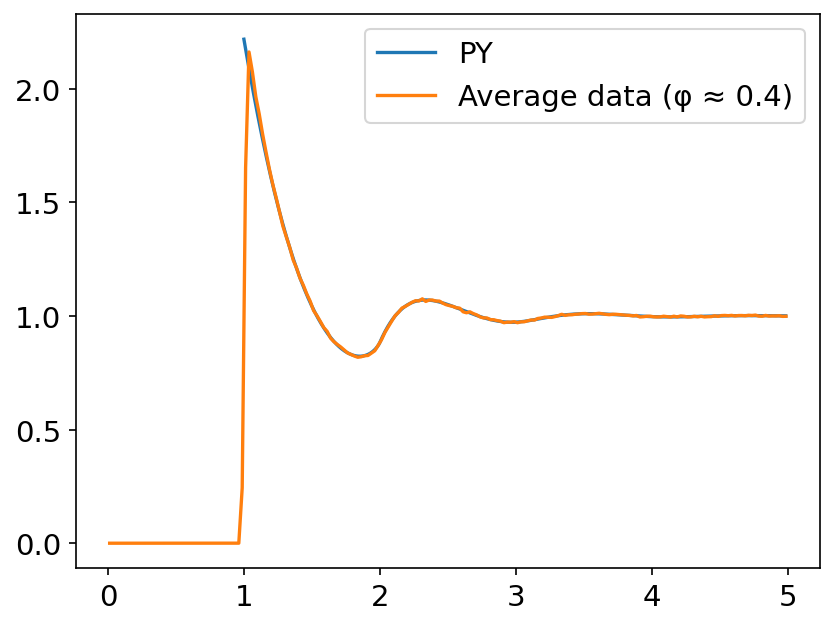

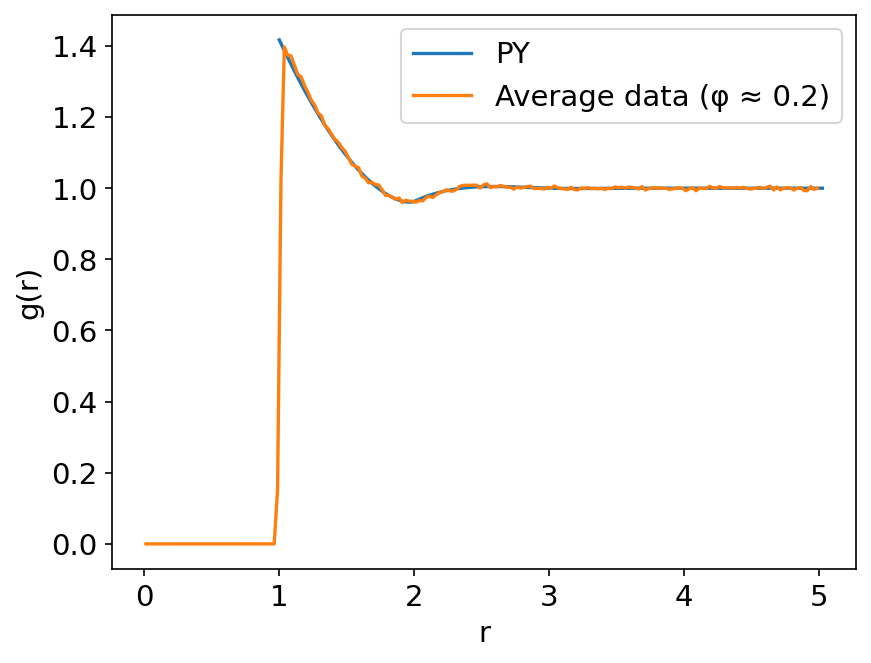

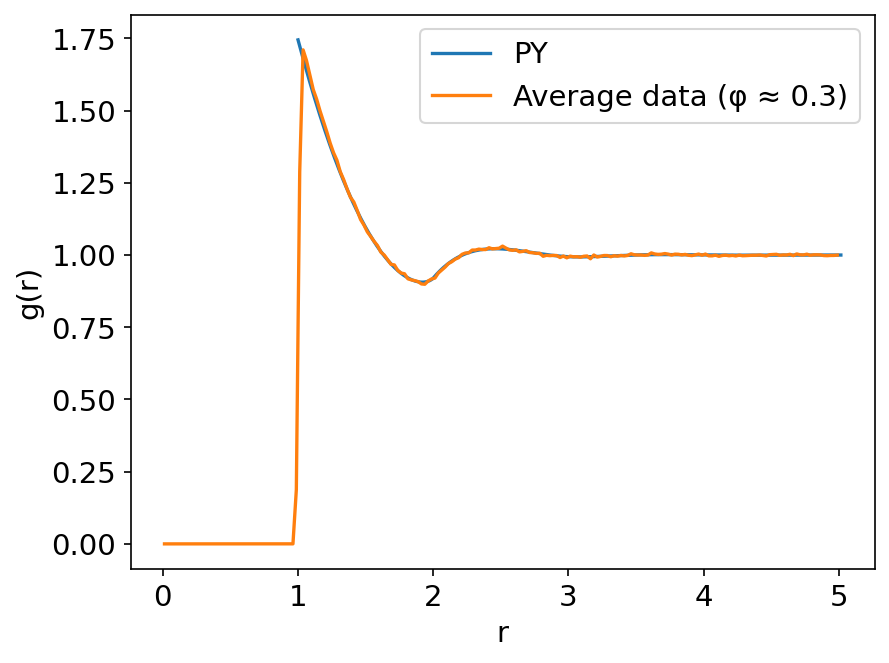

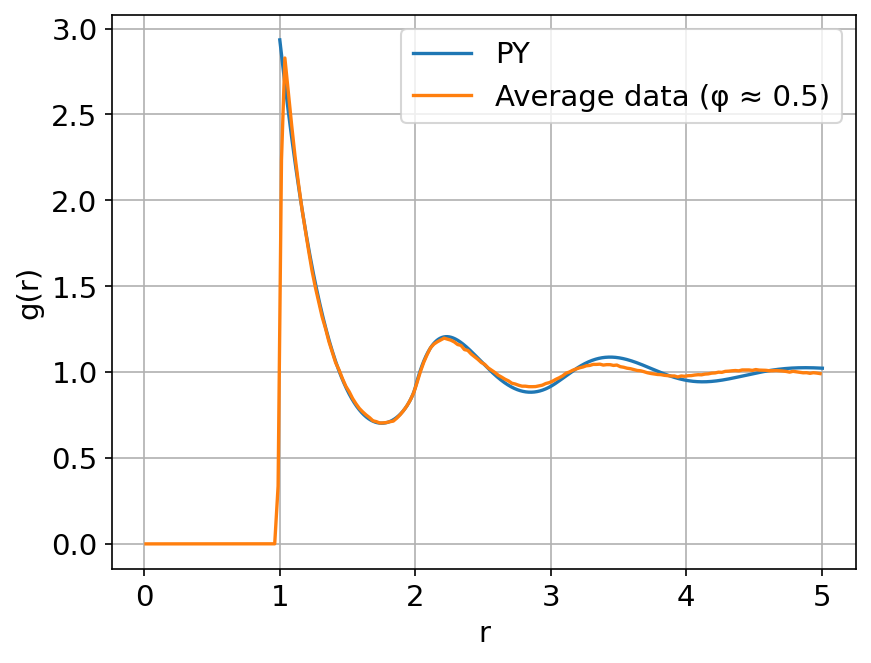

In [110]:
import numpy as np
import matplotlib.pyplot as plt

# Load the two-column data file
r4, g4 = np.loadtxt('PBP/PY_phi_40.dat', unpack=True)
r2, g2 = np.loadtxt('PBP/PY_phi_20.dat', unpack=True)
r5, g5 = np.loadtxt('PBP/PY_phi_50.dat', unpack=True)
r3, g3 = np.loadtxt('PBP/PY_phi_30.dat', unpack=True)
r23, g23 = np.loadtxt('PBP/py_ph_0.23.txt', unpack=True)
r43, g43 = np.loadtxt('PBP/py_ph_0.43.txt', unpack=True)
# Plot
plt.figure()
plt.plot(r4, g4, label='PY')
plt.plot(fil40["r"], fil40["g"], label="Average data (φ ≈ 0.4)")
plt.legend()
plt.figure()
plt.plot(r2, g2, label='PY')
plt.plot(fil20["r"], fil20["g"], label="Average data (φ ≈ 0.2)")
plt.xlabel('r')
plt.ylabel('g(r)')
#plt.title('Pair correlation function')
plt.legend()
plt.figure()
plt.plot(r3, g3, label='PY')
plt.plot(fil30["r"], fil30["g"], label="Average data (φ ≈ 0.3)")
plt.xlabel('r')
plt.ylabel('g(r)')
#plt.title('Pair correlation function')
plt.legend()
plt.figure()
plt.plot(r5, g5, label='PY')
plt.plot(fil50["r"], fil50["g"], label="Average data (φ ≈ 0.5)")
plt.xlabel('r')
plt.ylabel('g(r)')
#plt.title('Pair correlation function')
plt.legend()
plt.grid(True)

plt.show()


In [9]:
import matplotlib.pyplot as plt
#print(plt.style.available)
all_data = pd.read_csv('all_PBP_data.csv')

# Save average g(r) for each r and phi
avg_data = pd.read_csv('average_PBP_data.csv')
all_data, avg_data

(            r  phi         g
 0      0.0125  0.2  0.000000
 1      0.0375  0.2  0.000000
 2      0.0625  0.2  0.000000
 3      0.0875  0.2  0.000000
 4      0.1125  0.2  0.000000
 ...       ...  ...       ...
 27395  4.8875  0.5  0.998927
 27396  4.9125  0.5  0.991553
 27397  4.9375  0.5  1.006179
 27398  4.9625  0.5  0.994258
 27399  4.9875  0.5  0.986868
 
 [27400 rows x 3 columns],
            r  phi         g
 0     0.0125  0.2  0.000000
 1     0.0375  0.2  0.000000
 2     0.0625  0.2  0.000000
 3     0.0875  0.2  0.000000
 4     0.1125  0.2  0.000000
 ...      ...  ...       ...
 1395  4.8875  0.5  0.996733
 1396  4.9125  0.5  0.992882
 1397  4.9375  0.5  0.996649
 1398  4.9625  0.5  0.994434
 1399  4.9875  0.5  0.991387
 
 [1400 rows x 3 columns])

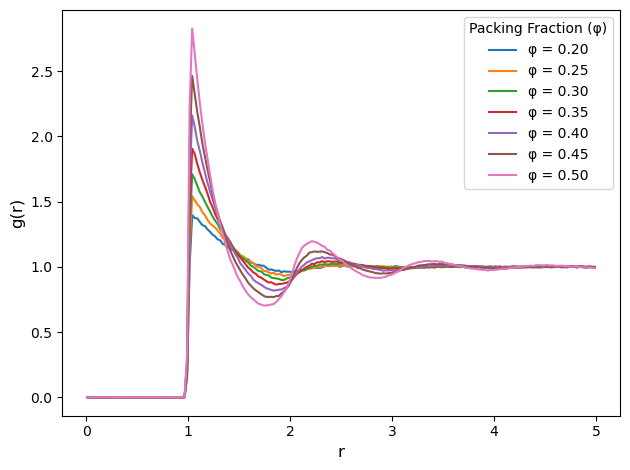

In [28]:
for phi, group in avg_data.groupby('phi'):
    
    plt.plot(group['r'], group['g'], label=f'φ = {phi:.2f}')
    plt.xlabel('r', fontsize=12)
    plt.ylabel('g(r)', fontsize=12)
    #plt.title('Radial Distribution Function g(r) for Different φ', fontsize=14)
    plt.legend(title='Packing Fraction (φ)')
    plt.tight_layout()
plt.show()

# $\text{Data Preprocessing for Machine learining}$

$\textbf{PyTorch}$ is a popular open-source deep learning library used for building and training neural networks. One of the key components of PyTorch is the Dataset and DataLoader classes, which provide an easy and efficient way to handle data in machine learning workflows. Check [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for more details.

In [59]:
all_data
d = all_data.to_numpy()
np.unique(d[:,-1])
d

array([[0.0125  , 0.2     , 0.      ],
       [0.0375  , 0.2     , 0.      ],
       [0.0625  , 0.2     , 0.      ],
       ...,
       [4.9375  , 0.5     , 1.006179],
       [4.9625  , 0.5     , 0.994258],
       [4.9875  , 0.5     , 0.986868]])

In [60]:
class correlationDataset(Dataset):
    def __init__(self, data):
        self.g_r = data
        
    def __len__(self):
        return self.g_r.shape[0]
        
    def __getitem__(self, idx):
        inputs = self.g_r[idx,:-1]
        g = self.g_r[idx,-1]    
        return torch.FloatTensor(inputs), torch.FloatTensor([g])

# $\text{Model design and training pipeline}$
Our model architecture will consist of a basic Multi-layer perceptron (MLP), also referred to as a fully connected neural network. The model will take in a vector of values, namely $[r, Pe]$, as input and produce a vector $[g(r)]$ as output. The number of hidden layers can also be adjusted using the input list ```hidden_dims = [layer_1, layer_2, ..., layer_n]```.

In [8]:
#Creation of model

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims): 
        super(MLP, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_dims[i-1], hidden_dims[i]) for i in range(1, len(hidden_dims))
        ])
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)
    
    def forward(self, x):
        x = nn.functional.relu(self.input_layer(x)) 
        for layer in self.hidden_layers:
            x = nn.functional.leaky_relu(layer(x)) 
        x = self.output_layer(x)
  
        return x

In [62]:
#Training of model 
def train_model(model, trainloader, testloader, loss_fn, optimizer, num_epochs):

    """
    Trains the model for num_epochs epochs and returns the test and train losses.
    """

    # Define lists to store the training and testing losses
    train_losses = []
    test_losses = []

    # Train the model
    for epoch in range(num_epochs):
        # Train the model on the training set
        train_loss = 0.0
        for i, data in enumerate(trainloader):
            # Get the inputs and targets
            inputs, targets = data
            inputs = inputs.to(device).float()   # ensure inputs are float32
            targets = targets.to(device).float()
            #print(targets)
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs.to(device))

            # Compute the loss
            loss = loss_fn(outputs, targets.to(device))

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Add the batch loss to the epoch loss
            train_loss += loss.item()

        # Compute the average training loss for the epoch
        train_loss /= len(trainloader)
        train_losses.append(train_loss)

        # Test the model on the test set
        test_loss = 0.0
        with torch.no_grad():
            for data in testloader:
                # Get the inputs and targets
                inputs, target = data

                # Forward pass
                outputs = model(inputs.to(device))

                # Compute the loss
                loss = loss_fn(outputs, target.to(device))

                # Add the batch loss to the epoch loss
                test_loss += loss.item()

        # Compute the average test loss for the epoch
        test_loss /= len(testloader)
        test_losses.append(test_loss)
        if epoch % 10 == 0:
        # Print the epoch number and loss
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    return train_losses, test_losses


1. hidden_dims = [128,128,128,128] batch_size = 256 (bad model)

# $\text{Evaluating the loss}$

In [63]:
#Creation of dataset and dataloader

from sklearn.model_selection import train_test_split
tr_set, te_set = train_test_split(d, test_size=0.1, random_state=42)
tr_set = correlationDataset(tr_set)
te_set = correlationDataset(te_set)
batch_size = 256
trainloader = DataLoader(tr_set, batch_size=batch_size, shuffle=True)
testloader= DataLoader(te_set, batch_size=batch_size, shuffle=True)

Epoch 1/100, Train Loss: 0.2627, Test Loss: 0.1341
Epoch 11/100, Train Loss: 0.0248, Test Loss: 0.0219
Epoch 21/100, Train Loss: 0.0097, Test Loss: 0.0085
Epoch 31/100, Train Loss: 0.0048, Test Loss: 0.0044
Epoch 41/100, Train Loss: 0.0029, Test Loss: 0.0030
Epoch 51/100, Train Loss: 0.0019, Test Loss: 0.0019
Epoch 61/100, Train Loss: 0.0014, Test Loss: 0.0013
Epoch 71/100, Train Loss: 0.0010, Test Loss: 0.0011
Epoch 81/100, Train Loss: 0.0008, Test Loss: 0.0007
Epoch 91/100, Train Loss: 0.0006, Test Loss: 0.0007


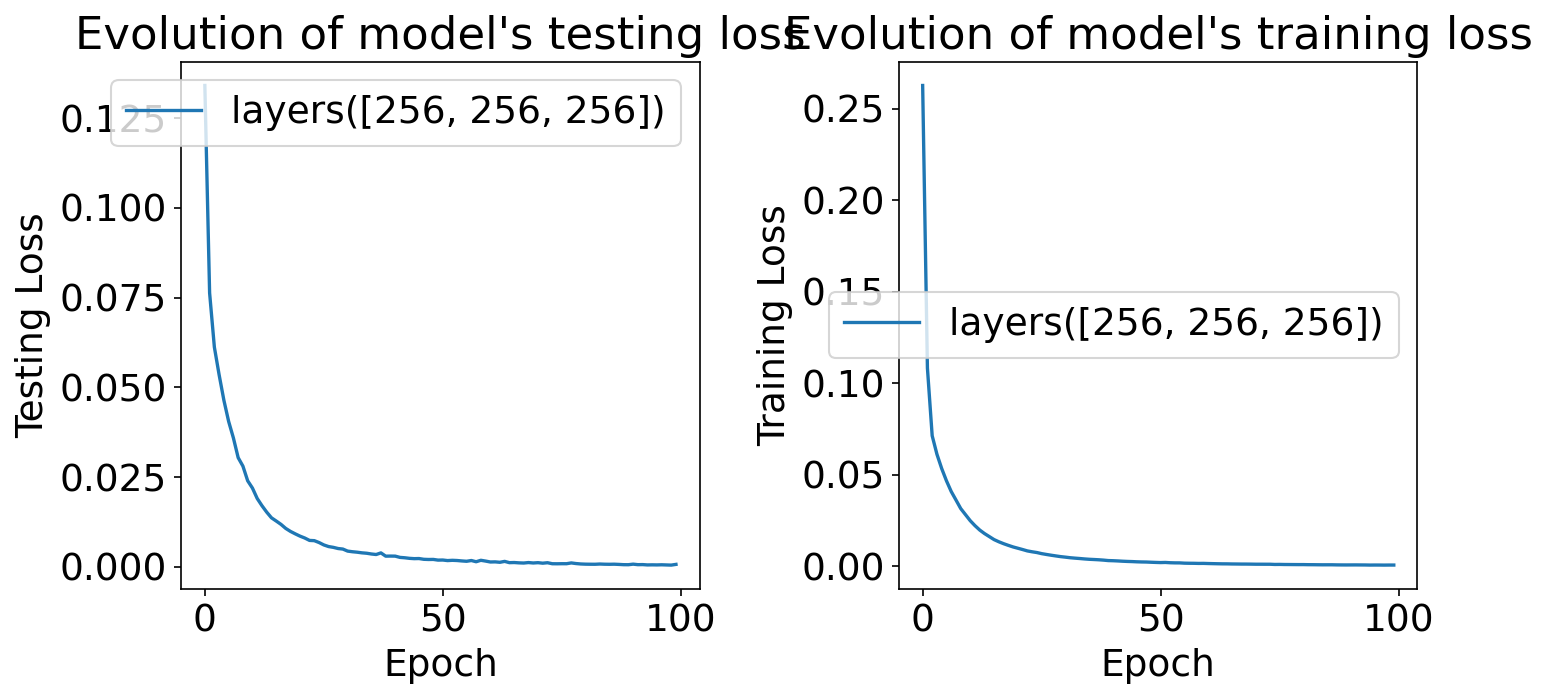

In [64]:
input_dim = 2 
output_dim = 1  
hidden_dims = [256,256,256]
# Create MLP model and optimizer
model1 = MLP(input_dim, output_dim, hidden_dims).to(device)
optimizer = optim.Adam(model1.parameters(), lr=5e-5)
# Define the loss function
loss_fn = nn.MSELoss()
# Set the number of epochs to train for
num_epochs = 100

train_losses, test_losses = train_model(model1, trainloader,
                                        testloader, loss_fn,
                                        optimizer, num_epochs)

#converting the losses in a dataframe to easily get the moving average 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.plot(np.arange(len(test_losses)),test_losses, label = f"layers({hidden_dims})")
ax1.set_title("Evolution of model's testing loss")
ax1.legend()
ax1.set_ylabel("Testing Loss")
ax1.set_xlabel("Epoch")

ax2.plot(np.arange(len(train_losses)),train_losses, label = f"layers({hidden_dims})")
ax2.set_title("Evolution of model's training loss")
ax2.legend()
plt.ylabel("Training Loss")
plt.xlabel("Epoch")

plt.tight_layout()
plt.show()


In [65]:
np.save('train_losses_PBP.npy', train_losses)   
#d = np.load('train_losses_PCF_ABP_pephir.npy')
np.save('test_losses_PBP.npy', test_losses)  

# Saving the model. 
After saving, you can load easily and work from this code below (of course you need to define the model first)

In [9]:
#save the model
#torch.save(model1.state_dict(), "PBP_NNmodel.pth")

# load the model
input_dim = 2 
output_dim = 1  
hidden_dims = [256,256,256]
model = MLP(input_dim, output_dim, hidden_dims).to(device)  # same architecture
model.load_state_dict(torch.load("PBP_NNmodel.pth"))
model.to(device)
model.eval()



MLP(
  (input_layer): Linear(in_features=2, out_features=256, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (output_layer): Linear(in_features=256, out_features=1, bias=True)
)

# Prediction using our DNN model

In [217]:
op = {}
phi = [0.2,0.23,0.3,0.4,0.43, 0.45]
num_r_values = 200
r = avg_data.iloc[:200, 0].values # 200 r values from 0 to 2

for p in phi:
    a = []
    for rr in r:
        
        i = torch.FloatTensor([rr,p]).to(device)
        with torch.no_grad():
            opp = model(i).item() # for hidden layer: [256,256,256]
        a.append(opp)
    op[p] = np.array(a)


# To plot for unknown and known parameters

In [51]:
import numpy as np
import glob
import os

phi_values = [0.23, 0.43]

for phi in phi_values:
    folder_path = f'PBP/phi_{phi}/'
    file_paths = sorted(glob.glob(os.path.join(folder_path, 'rdf*.txt')))

    if len(file_paths) == 0:
        raise RuntimeError(f"No rdf files found for phi={phi}")

    g_list = []

    for i, file in enumerate(file_paths):
        data = np.loadtxt(file)   # columns: r, g

        if i == 0:
            r = data[:, 0]        # store r-grid once

        g_list.append(data[:, 1]) # store g(r)

    # Stack and average over snapshots
    g_avg = np.mean(np.vstack(g_list), axis=0)

    # Combine r and averaged g
    out_data = np.column_stack((r, g_avg))

    # Write .dat file (no header)
    out_file = f'avg_rdf_phi_{phi}.dat'
    np.savetxt(out_file, out_data, fmt='%.5e')

    print(f"Saved: {out_file}  (snapshots = {len(file_paths)})")


Saved: avg_rdf_phi_0.23.dat  (snapshots = 20)
Saved: avg_rdf_phi_0.43.dat  (snapshots = 20)


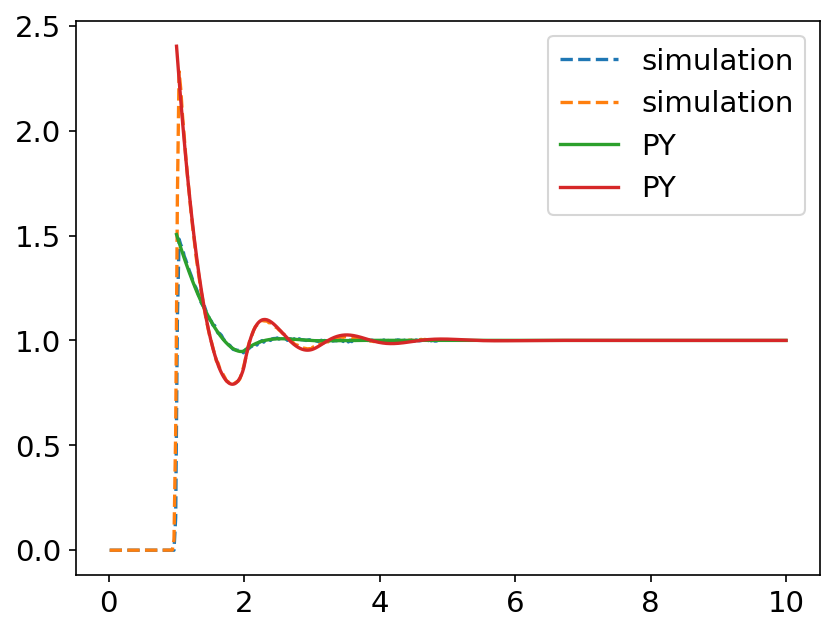

In [113]:
rsim23, gsim23 = np.loadtxt('PBP/avg_rdf_phi_0.23.dat', unpack=True)
rsim43, gsim43 = np.loadtxt('PBP/avg_rdf_phi_0.43.dat', unpack=True)
plt.plot(rsim23, gsim23, linestyle = '--', label = 'simulation')
plt.plot(rsim43, gsim43, linestyle = '--', label = 'simulation')
plt.plot(r23, g23, label = 'PY')
plt.plot(r43, g43, label = 'PY')
plt.legend(frameon=True)

# Visualiation of DNN prediction 
$\textbf{and comparing it with PY closure as well as the simulation data}$

In [222]:
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple

cases = [
    {"phi": 0.23, "marker": "o", "colour":"tab:green"},
    #{"phi": 0.30, "marker": "^", "colour":"tab:brown"},
    {"phi": 0.43, "marker": "s", "colour":"tab:pink"},
]

fig, ax = plt.subplots(figsize=(3.4, 2.6))
ax.set_facecolor("white")

# -----------------------------
# Axes styling
# -----------------------------
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.6)
    spine.set_color("black")

ax.tick_params(
    axis='both', which='both',
    direction='in', top=True, bottom=True, left=True, right=True,
    length=6, width=1.6
)
ax.minorticks_on()
ax.grid(False)
# PLOTTING---------------------------
for case in cases:
    phi = case["phi"]
    marker = case["marker"]
    col = case["colour"]
        
    # DNN (blue dashed)
    ax.plot(
        fil20["r"], op[phi],
        color='tab:blue',
        linestyle='--',
        linewidth=2.2,
        zorder=1
        )

    # Select data
    if phi == 0.23:
        r_sim, g_sim = rsim23, gsim23
        r_py, g_py = r23, g23
    elif phi == 0.43:
        r_sim, g_sim = rsim43, gsim43
        r_py, g_py = r43, g43
    elif phi == 0.3:
        r_py, g_py = r3, g3
        r_sim, g_sim = fil30["r"].values,fil30["g"].values
        
    # PY (orange, sparse) plotting
    ax.plot(
        r_py, g_py,
        color='#D55E00',
        linewidth=1.8,
        zorder=2
        #markerfacecolor='none'
        )
    
    r_dense_min = 0.8
    r_dense_max = 1.15
    sparse_step = 6
    
    # Dense region mask
    mask_dense = (r >= r_dense_min) & (r <= r_dense_max)
    idx_dense = np.where(mask_dense)[0]
    # Sparse region mask (outside dense window)
    mask_sparse = ~mask_dense
    idx_sparse_all = np.where(mask_sparse)[0]
    idx_sparse = idx_sparse_all[::sparse_step]
    # Make sure peak is included
    idx_plot = np.unique(np.concatenate([idx_sparse, idx_dense]))
    
    # Simulation (black markers only)    
    ax.plot(
        r_sim[idx_plot], g_sim[idx_plot],
        color=col,
        linestyle='none',
        marker=marker,
        markersize=4.0,
        markeredgewidth=1.3,
        markerfacecolor='white',
        zorder=5
    )
    

phi_legend = [
        Line2D([0], [0],
               color= case['colour'], #'black',
               marker=case["marker"],
               linestyle='none',
               markersize=4,
               markerfacecolor='white',
               label=rf"$\varphi$ = {case['phi']}") #$\varphi = {case['phi']}$, 
        for case in cases
    ]
leg_phi = ax.legend(
    handles=phi_legend,
    #title=r'$\varphi$',
    loc='lower right',
    frameon=True,
    #fontsize=10,
)

ax.add_artist(leg_phi)


model_legend = [
       
    Line2D([0], [0], color='tab:blue', linestyle='--', linewidth=2, label='DNN'), 
    Line2D([0], [0], color='#D55E00',linewidth=2, label='PY'),
]

ax.legend(
    handles=model_legend,
    labels=[ 'DNN', 'PY'], #'Simulation',
    handler_map={tuple: HandlerTuple(ndivide=None)},
    loc='upper right',
    frameon=True,
    #fontsize=10
)

ax.set_xlim(0, 5.01)
ax.set_ylim(0, None)
#ax.set_ylabel(rf'g(r)')
#ax.set_xlabel(rf'$r/\sigma$')
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)
ax.tick_params(direction='in', length=6, width=1)

plt.tight_layout()
#plt.show()
plt.savefig(out_dir / "PBP_all_phi_models_clean.svg", bbox_inches="tight")
plt.close()


$\textbf{Data preparation for Symbolic regression (PySR)}$

In [11]:
phi1 = np.round(np.linspace(0.2,0.4,10),3)
phi2 = np.round(np.linspace(0.4,0.5,20),3)
phi = np.concatenate((phi1,phi2))

In [13]:
op_pysr = {}
num_r_values = 200
r = avg_data.iloc[:200, 0].values # 200 r values from 0 to 2

for p in phi:
    a = []
    for rr in r:
        i = torch.FloatTensor([rr,p]).to(device)
        with torch.no_grad():
            opp = model(i).item() # for hidden layer: [256,256,256]
        a.append(opp)
    op_pysr[p] = np.array(a)

In [182]:
Phi_grid, r_grid = np.meshgrid(
    phi, r, indexing='ij'
)
# Flatten to 1D arrays
phi_flat = Phi_grid.ravel()
r_flat = r_grid.ravel()

# Stack into input array
X_pred = np.stack([r_flat, phi_flat], axis=1)
print("Shape of X_pred:", X_pred.shape)

X_tensor = torch.tensor(X_pred, dtype=torch.float32).to(device)
model1.eval()  # set model to evaluation mode

with torch.no_grad():
    y_pred = model1(X_tensor).cpu().numpy() 
y_pred = np.clip(y_pred, a_min=0.0, a_max=None)
print("Shape of y_pred:", y_pred.shape)
print("y_pred shape:", y_pred.shape)
print("predicted g range:", y_pred.min(), y_pred.max())

np.save("PBP_inp.npy", X_pred) #logPe,phi, cos_theta, sin_theta, r
np.save("PBP_op.npy", y_pred)

Shape of X_pred: (6000, 2)
Shape of y_pred: (6000, 1)
y_pred shape: (6000, 1)
predicted g range: 0.0 2.815027


# Symbolic regression output (main code is given as .py file separately):

In [23]:
import joblib
X = np.load("PBP_inp.npy")
ground_truth = np.load("PBP_op.npy")
# Load the model
PBP_model = joblib.load('../my_saved_pysr_new/new_pysr_model_PBP.pkl')
#PBP_model.sympy()
import sympy as sp
import numpy as np

expr = PBP_model.sympy()    # symbolic expression
r, phi = sp.symbols('r phi')   # r, phi

# Create a numpy-callable function
f_model = sp.lambdify((r, phi), expr, 'numpy')
np.max(f_model(r2, 0.6))

/home/wdasgupta/miniconda3/envs/gpu_wd/lib/python3.10/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


exp((phi*0.2961854)**r*sin(r*(phi*r + r))/0.14065117)*cos(exp(r**27.302364*(-1.5679094)/r))**48.932907

# Symbolic regression plot

NameError: name 'fil20' is not defined

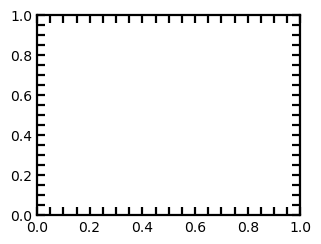

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.legend_handler import HandlerTuple

fig, ax = plt.subplots(figsize=(3.4, 2.6))
ax.set_facecolor("white")

# -----------------------------
# Axes styling
# -----------------------------
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.6)
    spine.set_color("black")

ax.tick_params(
    axis='both', which='both',
    direction='in', top=True, bottom=True, left=True, right=True,
    length=6, width=1.6
)
ax.minorticks_on()
ax.grid(False)

# PLOTTING---------------------------

cases = [
    {"phi": 0.2, "marker": "o", "colour":"tab:olive"},
    {"phi": 0.3, "marker": "^", "colour":"tab:gray"},
    {"phi": 0.45, "marker": "s", "colour":"tab:pink"},
]

for case in cases:
    phi = case["phi"]
    marker = case["marker"]
    col = case["colour"]
        
    # DNN (blue dashed)
    ax.plot(
        fil20["r"], op[phi],
        color='tab:blue',
        linestyle='--',
        linewidth=3.0,
        zorder=1
        )
    # Symbolic regression plotting----
    ax.plot(
        fil20["r"],
        f_model(fil20["r"], phi),
        color='tab:red',
        linewidth=1.5,
        zorder = 2
        )

    # Select data for simulation plot
    if phi == 0.2:
        r_sim, g_sim = fil20["r"].values,fil20["g"].values
    elif phi == 0.4:
        r_sim, g_sim = fil40["r"].values,fil40["g"].values
    elif phi == 0.3:
        r_sim, g_sim = fil30["r"].values,fil30["g"].values
    elif phi == 0.45:
        r_sim, g_sim = fil45["r"].values,fil45["g"].values

    r_dense_min = 1.0
    r_dense_max = 1.13
    sparse_step = 10
    
    # Dense region mask
    mask_dense = (r >= r_dense_min) & (r <= r_dense_max)
    idx_dense = np.where(mask_dense)[0]
    # Sparse region mask (outside dense window)
    mask_sparse = ~mask_dense
    idx_sparse_all = np.where(mask_sparse)[0]
    idx_sparse = idx_sparse_all[::sparse_step]
    # Make sure peak is included
    idx_plot = np.unique(np.concatenate([idx_sparse, idx_dense]))
    
    # Simulation (black markers only)    
    ax.plot(
        r_sim[idx_plot], g_sim[idx_plot],
        color=col,
        linestyle='none',
        marker=marker,
        markersize=4.0,
        markeredgewidth=1.3,
        markerfacecolor='white',
        zorder=5
    )
    
phi_legend = [
        Line2D([0], [0],
               color= case['colour'], #'black',
               marker=case["marker"],
               linestyle='none',
               markersize=5,
               markerfacecolor='white',
               label=rf"$\varphi$ = {case['phi']:.2f}") #$\varphi = {case['phi']}$, 
        for case in cases
    ]
leg_phi = ax.legend(
    handles=phi_legend,
    #title=r'$\varphi$',
    loc='lower right',
    frameon=True,
    #fontsize=10,
)

ax.add_artist(leg_phi)

model_legend = [    
    Line2D([0], [0], color='tab:blue', linestyle='--', linewidth=2, label='DNN'), 
    Line2D([0], [0], color='tab:red',linewidth=2, label='Symbolic\nregression'), 
]

ax.legend(
    handles=model_legend,
    #labels=[ 'DNN', 'Simulation'], #'Simulation',
    handler_map={tuple: HandlerTuple(ndivide=None)},
    loc='upper right',
    frameon=True,
    #fontsize=10
)
ax.set_xlim(0, None)
ax.set_ylim(0, None)

ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)
ax.tick_params(direction='in', length=6, width=1.2)

plt.tight_layout()
plt.show()
#plt.savefig(out_dir / "PBP_all_phi_symbolic.svg", bbox_inches="tight")
plt.close()

